### Universidad de Granada | ETSIIT | Escuela Internacional de Posgrado
---
# **Proyecto Final**: Naïve Bayes
---
**Asignatura:** Minería de Datos: Preprocesamiento y Clasificación

**Autor:** Lugli, Valentino Glauco · YB0819879

# Librerías y Datos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
from tabulate import tabulate
import pickle
import optuna
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.neighbors import LocalOutlierFactor

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [2]:
df_credit = pd.read_csv("../data_preprocess/train_preprocess.csv").drop(columns=["ID"])

df_credit_x = df_credit.drop(columns=["RATE"])
df_credit_y = df_credit["RATE"]

df_test = pd.read_csv("../data_preprocess/test_preprocess.csv")
X_test     = df_test.drop(columns=["ID"])
X_test_ids = df_test["ID"]

# Funciones

In [3]:
def naive_bayes_fits(results, x_train, y_train, x_val, y_val, show_cf = True):

    for model in results:

        y_pred_train = results[model]["model"].fit(x_train, y_train).predict(x_train)
        y_pred_val   = results[model]["model"].predict(x_val)
        results[model]["train_stats"] = classification_report(y_train, y_pred_train, output_dict=True, zero_division=0)
        results[model]["val_stats"]  = classification_report(y_val, y_pred_val, output_dict=True, zero_division=0)
        results[model]["val_conf"]  = confusion_matrix(y_val, y_pred_val)
        results[model]["val_pred"]  = y_pred_val
        results[model]["train_pred"]  = y_pred_train   

    # print(tabulate(body, headers=header, floatfmt=".4f"))
    naive_bayes_stats(results, show_cf=show_cf)

    return results

def naive_bayes_stats(results, show_cf = True):
    
    header = ["Variant", "F1 Score", "Train Acc", "Test Acc", "Parameters"]
    body = []
    matrices = []

    for m in results:
        body.append([m, results[m]["val_stats"]["macro avg"]["f1-score"], results[m]["train_stats"]["accuracy"] * 100, results[m]["val_stats"]["accuracy"] * 100, results[m]["params"]])
        matrices.append(results[m]["val_conf"])
    print(tabulate(body, headers=header, floatfmt=".4f"))

    if(show_cf):
        fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(18, 4))

        tick_labels = ["A", "B", "C", "D"]

        if(len(matrices) > 1):
            axes = axes.flatten()
        else:
            curr_ax = axes

        for i, model in enumerate(results):
            if(len(matrices) > 1):
                curr_ax = axes[i]

            sns.heatmap(matrices[i], ax=curr_ax, annot=True, xticklabels=tick_labels, yticklabels=tick_labels)
            curr_ax.title.set_text(model)
            curr_ax.set_xlabel("Predicted") 
            curr_ax.set_ylabel("Real") 

        plt.tight_layout()
        plt.show()

def to_kaggle(pred, id, path=".", fname="kaggle_out"):
    kaggle_dict = {"ID" : id, "RATE" : pred}
    pd.DataFrame(data=kaggle_dict).to_csv("{}/{}.csv".format(path, fname), index=False)

def get_kaggle_pred(model, data, id, path=".", fname="kaggle_out"):
    model_pred = model.predict(data)
    to_kaggle(model_pred, id, path=path, fname=fname)

In [4]:
def set_scaler(scaler, X_train_in, X_val_in, X_test_in):
    scaler.fit(X_train_in)

    X_train_out = pd.DataFrame(scaler.transform(X_train_in), columns=X_train_in.columns)
    X_val_out   = pd.DataFrame(scaler.transform(X_val_in), columns=X_train_in.columns)
    X_test_out  = pd.DataFrame(scaler.transform(X_test_in), columns=X_train_in.columns)

    return X_train_out, X_val_out, X_test_out


def set_PCA(X_train_in, X_val_in, X_test_in, ratio):
    explained_variance_ratio = 0
    i = 0
    while(explained_variance_ratio < ratio):
        i += 1
        pca = PCA(n_components=i)
        pca.fit(X_train_in)
        explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

    X_train_out = pd.DataFrame(pca.transform(X_train_in))
    X_val_out   = pd.DataFrame(pca.transform(X_val_in))
    X_test_out  = pd.DataFrame(pca.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def discretize(X_train_in, X_val_in, X_test_in, bins, enconder, strat):
    discretizer = KBinsDiscretizer(n_bins=bins, encode=enconder, strategy=strat)

    X_train_out = pd.DataFrame(discretizer.fit_transform(X_train_in), columns=discretizer.get_feature_names_out())
    X_val_out   = pd.DataFrame(discretizer.transform(X_val_in), columns=discretizer.get_feature_names_out())
    X_test_out  = pd.DataFrame(discretizer.transform(X_test_in), columns=discretizer.get_feature_names_out())

    return X_train_out, X_val_out, X_test_out
 
def feature_perc(X_train_in, y_train_in, X_val_in, X_test_in, percent):
    fs = SelectPercentile(score_func=f_classif, percentile=percent)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def feature_top(X_train_in, y_train_in, X_val_in, X_test_in, k):
    fs = SelectKBest(score_func=f_classif, k=k)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def get_lof(X_train_in, y_train_in, neigh):
    lof = LocalOutlierFactor(n_neighbors=neigh)
    yhat = lof.fit_predict(X_train_in)

    mask = yhat != -1
    X_train_out, y_train_out = X_train_in[mask], y_train_in[mask]  

    return X_train_out, y_train_out

def down_sample(X_train_in, y_train_in, neigh):
    X_train_out, y_train_out = NearMiss(version=2, n_neighbors=neigh).fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def up_sample(X_train_in, y_train_in, neigh):
    sm = SMOTE(random_state=16, k_neighbors=neigh)
    X_train_out, y_train_out = sm.fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # print('Correlated Columns are: {}'.format(sorted(drops)))
    return drops

def delete_corr(X_train_in, X_val_in, X_test_in, corr_val):
    collinear_cols = get_collinear_features(X_train_in, corr_val)
    X_train_out = X_train_in.drop(columns=collinear_cols)
    X_val_out   = X_val_in.drop(columns=collinear_cols)
    X_test_out  = X_test_in.drop(columns=collinear_cols)

    return X_train_out, X_val_out, X_test_out

# DISCRETO

In [94]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [136]:
results = {
    # "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}
out = naive_bayes_fits(results, X_train, y_train, X_val, y_val)

In [135]:
X_train, X_val, X_test = discretize(X_train, X_val, X_test, 30, enconder="onehot-dense", strat="uniform")

/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [67]:
get_kaggle_pred(out["categorical_1"]["model"], X_test, X_test_ids, fname="nb_categorical__raw")

NameError: name 'out' is not defined

In [104]:
out["categorical_1"]["model"]

CategoricalNB(force_alpha=True)

In [106]:

# open a file, where you ant to store the data
file = open('best_categorical.pkl', 'wb')

# dump information to that file
pickle.dump(out["categorical_1"]["model"], file)

# close the file
file.close()

In [ ]:
pickle.dump(out["categorical_1"]["model"])

# Optuna

In [75]:
class TuningParams:
    def __init__(self, X_data, y_data, X_test) -> None:
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_data, 
                                                            y_data, stratify=y_data, 
                                                            test_size=0.2, 
                                                            random_state=16)
        self.X_test = X_test.drop(columns=["ID"])
        self.X_test_ids = X_test["ID"]
        self.trial = {}

        self.scalers = {"std" : StandardScaler(), 
                        "norm" : Normalizer(), 
                        "quan" : QuantileTransformer(n_quantiles=600), 
                        "power" : PowerTransformer()}

    def objective_function(self, trial):
        X_train = self.X_train
        y_train = self.y_train
        X_val   = self.X_val
        y_val   = self.y_val
        X_test  = self.X_test

        # Standarization
        scaler = trial.suggest_categorical("scaler", ["std", "norm", "quan", "power"])
        X_train, X_val, X_test = set_scaler(self.scalers[scaler], X_train, X_val, X_test)

        # LOF
        do_LOF = trial.suggest_categorical("lof", [True, False])

        if(do_LOF):
            neigs = trial.suggest_int("lof_neighs", 10, 30)
            X_train, y_train = get_lof(X_train, y_train, neigs)

        # Feature Selection
        do_feat_sel = trial.suggest_categorical("feature_selection", [True, False])

        if(do_feat_sel):
            sel_type = trial.suggest_categorical("feat_sel_type", ["top", "perc"])

            if(sel_type == "top"):
                best_k = trial.suggest_int("top_k", 5, 25)
                X_train, X_val, X_test = feature_top(X_train, y_train, X_val, X_test, best_k)
            else:
                perc = trial.suggest_int("perc", 5, 25)
                X_train, X_val, X_test = feature_perc(X_train, y_train, X_val, X_test, perc)

        # Correlated Columns
        delete_correlated = trial.suggest_categorical("delete_correlated", [True, False])
        if(delete_correlated):
            corr_val = trial.suggest_float("corr_value", 0.5, 0.8)
            X_train, X_val, X_test = delete_corr(X_train, X_val, X_test, corr_val)
        
        # PCA
        do_PCA = trial.suggest_categorical("pca", [True, False])

        if(do_PCA):
            ratio = trial.suggest_float("pca_ratio", 0.5, 0.95)
            X_train, X_val, X_test = set_PCA(X_train, X_val, X_test, ratio)

        # Under/Oversampling
        do_resampling = trial.suggest_categorical("resample", [True, False])

        if(do_resampling):
            kind = trial.suggest_categorical("kind", ["up", "down"])
            if(kind == "up"):
                neigs = trial.suggest_int("up_neighs", 2, 10)
                X_train, y_train = up_sample(X_train, y_train, neigs)
            else:
                neigs = trial.suggest_int("down_neighs", 2, 10)
                X_train, y_train = down_sample(X_train, y_train, neigs)


        try:
            # Fitting and testing...
            nb_type = trial.suggest_categorical("nb_type", ["gauss", "categorical", "complement", "bernoulli"])
            if(nb_type == "gauss"):
                var_smoothing = trial.suggest_float("gauss_var_smoothing", 1e-10, 1e-3)
                model = GaussianNB(var_smoothing=var_smoothing)
            else:
                discr_bins = trial.suggest_int("discr_bins", 10, 75)
                discr_encoder = trial.suggest_categorical("discr_encoder", ["onehot-dense", "ordinal"])
                discr_strat = trial.suggest_categorical("discr_strat", ["uniform", "quantile", "kmeans"])

                X_train, X_val, X_test = discretize(X_train, X_val, X_test, discr_bins, discr_encoder, discr_strat)

                alpha = trial.suggest_float("discrete_alpha", 0, 1)
                if(nb_type == "categorical"):
                    model = CategoricalNB(force_alpha=True, alpha=alpha)
                elif(nb_type == "complement"):
                    model = ComplementNB(force_alpha=True, alpha=alpha)
                else:
                    model = BernoulliNB(force_alpha=True, alpha=alpha)

            y_train_pred = model.fit(X_train, y_train).predict(X_train)
            y_val_pred   = model.predict(X_val)
            y_test_pred  = model.predict(X_test)

        except Exception:
            return -1

        self.trial[trial.number] = {}
        self.trial[trial.number]["train_stats"] = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_stats"]   = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_conf"]    = confusion_matrix(y_val, y_val_pred)
        self.trial[trial.number]["train_pred"]  = y_train_pred
        self.trial[trial.number]["val_pred"]    = y_val_pred
        self.trial[trial.number]["test_pred"]   = y_test_pred
        self.trial[trial.number]["model"]       = model
        
        act_acc = self.trial[trial.number]["val_stats"]["accuracy"]
        act_f1  = self.trial[trial.number]["val_stats"]["macro avg"]["f1-score"]

        fitness = np.mean([act_acc, act_f1])

        self.trial[trial.number]["fitness"] = fitness

        return fitness

    def get_trial_test(self, num_trial):
        return self.trial[num_trial]
    
    def get_k_best_trials(self, study, k=5, save_kaggle=False, show_cf=True, path="."):
        trials = study.best_trials[:k]
        results = {}
        for t in trials:
            act_name = "{}__{}".format(study.study_name, t.number)
            act_result = self.get_trial_test(t.number)
            act_result["params"] = t.params

            results[act_name] = act_result
            if(save_kaggle):
                self.trial_to_kaggle(act_result, path = path, fname = act_name)

        naive_bayes_stats(results, show_cf=show_cf)
        return results
    
    def trial_to_kaggle(self, trial, path=".", fname = "kaggle_out"):
        to_kaggle(trial["test_pred"], self.X_test_ids, path=path, fname = fname)


In [45]:
BNTuning = TuningParams(df_credit_x, df_credit_y, df_test)

In [77]:
study = optuna.create_study(direction="maximize", study_name="tuning__{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), storage="sqlite:///db.sqlite3")

study.optimize(BNTuning.objective_function, n_trials=1000)

[I 2024-01-10 12:29:52,009] A new study created in RDB with name: tuning__20240110-122951
[I 2024-01-10 12:29:52,495] Trial 0 finished with value: 0.306305261745747 and parameters: {'scaler': 'std', 'lof': False, 'feature_selection': False, 'delete_correlated': True, 'corr_value': 0.5765268490726685, 'pca': True, 'pca_ratio': 0.8320661383483157, 'resample': True, 'kind': 'down', 'down_neighs': 5, 'nb_type': 'gauss', 'gauss_var_smoothing': 0.000955117132269733}. Best is trial 0 with value: 0.306305261745747.
/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
[I 2024-01-10 12:29:52,837] Trial 1 finished with value: 0.40017570832418187 and parameters: {'scaler': 'quan', 'lof': True, 'lof_neighs': 19,

In [48]:
study.best_params

{'scaler': 'quan',
 'lof': False,
 'feature_selection': False,
 'delete_correlated': False,
 'pca': False,
 'resample': False,
 'nb_type': 'categorical',
 'discr_bins': 33,
 'discr_encoder': 'ordinal',
 'discr_strat': 'uniform',
 'discrete_alpha': 0.16637065913436855}

In [49]:
a = study.best_trials

In [50]:
a

[FrozenTrial(number=502, state=TrialState.COMPLETE, values=[0.643702505462374], datetime_start=datetime.datetime(2024, 1, 10, 12, 2, 32, 617513), datetime_complete=datetime.datetime(2024, 1, 10, 12, 2, 32, 800080), params={'scaler': 'quan', 'lof': False, 'feature_selection': False, 'delete_correlated': False, 'pca': False, 'resample': False, 'nb_type': 'categorical', 'discr_bins': 33, 'discr_encoder': 'ordinal', 'discr_strat': 'uniform', 'discrete_alpha': 0.16637065913436855}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'scaler': CategoricalDistribution(choices=('std', 'norm', 'quan', 'power')), 'lof': CategoricalDistribution(choices=(True, False)), 'feature_selection': CategoricalDistribution(choices=(True, False)), 'delete_correlated': CategoricalDistribution(choices=(True, False)), 'pca': CategoricalDistribution(choices=(True, False)), 'resample': CategoricalDistribution(choices=(True, False)), 'nb_type': CategoricalDistribution(choices=('gauss', 'categori

In [210]:
study.best_trial.params

{'standarize': True,
 'scaler': 'power',
 'lof': True,
 'lof_neighs': 10,
 'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 17,
 'delete_correlated': False,
 'pca': False,
 'resample': False}

In [19]:
self_trials = BNTuning.trial

In [188]:
BNTuning.trial = self_trials

Variant                         F1 Score    Train Acc    Test Acc  Parameters
----------------------------  ----------  -----------  ----------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
tuning__20240110-120047__502      0.6391      82.8729     64.8352  {'scaler': 'quan', 'lof': False, 'feature_selection': False, 'delete_correlated': False, 'pca': False, 'resample': False, 'nb_type': 'categorical', 'discr_bins': 33, 'discr_encoder': 'ordinal', 'discr_strat': 'uniform', 'discrete_alpha': 0.16637065913436855}


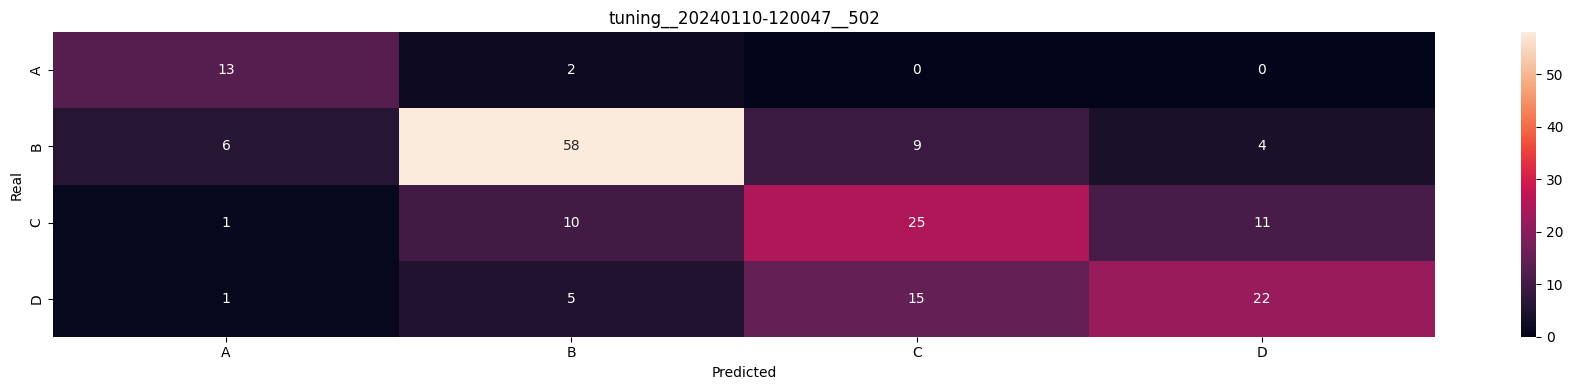

In [51]:
out = BNTuning.get_k_best_trials(study, k=1,save_kaggle=True);

In [219]:
out["tuning__20240109-170403__378"]["params"]

{'standarize': True,
 'scaler': 'power',
 'lof': True,
 'lof_neighs': 12,
 'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 24,
 'delete_correlated': False,
 'pca': False,
 'resample': False}

In [52]:
a = study.get_trials()

In [74]:
a[544].params

{'scaler': 'quan',
 'lof': False,
 'feature_selection': False,
 'delete_correlated': False,
 'pca': False,
 'resample': False,
 'nb_type': 'bernoulli',
 'discr_bins': 33,
 'discr_encoder': 'onehot-dense',
 'discr_strat': 'uniform',
 'discrete_alpha': 0.2076978780091387}

In [53]:
trials = study.trials_dataframe()

In [54]:
trials = trials.sort_values(by=["value"], ascending=False)

In [76]:
trials

,number,value,datetime_start,datetime_complete,duration,params_corr_value,params_delete_correlated,params_discr_bins,params_discr_encoder,params_discr_strat,...,params_nb_type,params_pca,params_pca_ratio,params_perc,params_resample,params_scaler,params_top_k,params_up_neighs,user_attrs_num_cols,state
999,999,0.643703,2024-01-10 12:04:52.415753,2024-01-10 12:04:52.663903,0 days 00:00:00.248150,NaN,False,33.0,ordinal,uniform,...,categorical,False,NaN,NaN,False,quan,NaN,NaN,NaN,COMPLETE
630,630,0.643703,2024-01-10 12:03:11.196016,2024-01-10 12:03:11.379229,0 days 00:00:00.183213,NaN,False,33.0,ordinal,uniform,...,categorical,False,NaN,NaN,False,quan,NaN,NaN,NaN,COMPLETE
739,739,0.643703,2024-01-10 12:03:39.555322,2024-01-10 12:03:39.790951,0 days 00:00:00.235629,NaN,False,33.0,ordinal,uniform,...,categorical,False,NaN,NaN,False,quan,NaN,NaN,NaN,COMPLETE
793,793,0.643703,2024-01-10 12:03:55.181959,2024-01-10 12:03:55.417761,0 days 00:00:00.235802,NaN,False,33.0,ordinal,uniform,...,categorical,False,NaN,NaN,False,quan,NaN,NaN,NaN,COMPLETE
732,732,0.643703,2024-01-10 12:03:37.425731,2024-01-10 12:03:37.665914,0 days 00:00:00.240183,NaN,False,33.0,ordinal,uniform,...,categorical,False,NaN,NaN,False,quan,NaN,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,576,-1.000000,2024-01-10 12:02:56.117604,2024-01-10 12:02:56.455360,0 days 00:00:00.337756,NaN,False,57.0,onehot-dense,uniform,...,categorical,True,0.612994,NaN,False,quan,NaN,NaN,NaN,COMPLETE
633,633,-1.000000,2024-01-10 12:03:11.804472,2024-01-10 12:03:12.303994,0 days 00:00:00.499522,NaN,False,31.0,onehot-dense,uniform,...,categorical,False,NaN,NaN,False,power,NaN,NaN,NaN,COMPLETE
639,639,-1.000000,2024-01-10 12:03:13.353884,2024-01-10 12:03:13.712211,0 days 00:00:00.358327,NaN,False,33.0,onehot-dense,uniform,...,categorical,False,NaN,NaN,True,quan,NaN,NaN,NaN,COMPLETE
471,471,-1.000000,2024-01-10 12:02:24.684966,2024-01-10 12:02:24.856329,0 days 00:00:00.171363,0.769201,True,33.0,onehot-dense,kmeans,...,categorical,False,NaN,NaN,False,norm,22.0,NaN,39.0,COMPLETE


In [32]:
trials_np = trials[["number"]].to_numpy()

In [33]:
trials_np

array([[350],
       [444],
       [580],
       [540],
       [181],
       [174],
       [173],
       [731],
       [172],
       [171],
       [167],
       [166],
       [629],
       [918],
       [347],
       [949],
       [524],
       [352],
       [354],
       [719],
       [361],
       [642],
       [373],
       [649],
       [761],
       [560],
       [558],
       [396],
       [790],
       [688],
       [744],
       [784],
       [767],
       [992],
       [593],
       [612],
       [812],
       [834],
       [905],
       [490],
       [983],
       [597],
       [608],
       [463],
       [896],
       [436],
       [379],
       [376],
       [264],
       [292],
       [256],
       [335],
       [319],
       [298],
       [246],
       [182],
       [175],
       [176],
       [177],
       [305],
       [704],
       [244],
       [241],
       [253],
       [240],
       [239],
       [238],
       [234],
       [233],
       [232],
       [231],
      

In [272]:
t_dict = trials.to_dict()

In [285]:
t_dict["value"].keys()

dict_keys([941, 973, 934, 971, 970, 933, 968, 967, 946, 965, 962, 957, 955, 954, 930, 929, 947, 928, 927, 948, 949, 952, 925, 950, 926, 972, 951, 978, 990, 979, 936, 942, 945, 938, 989, 988, 977, 943, 976, 991, 995, 986, 996, 998, 935, 981, 624, 686, 691, 696, 684, 700, 626, 681, 627, 628, 637, 683, 621, 922, 902, 892, 924, 906, 910, 914, 618, 919, 918, 909, 106, 736, 793, 794, 739, 818, 852, 787, 763, 758, 766, 884, 753, 767, 881, 751, 750, 772, 878, 773, 749, 774, 747, 779, 744, 743, 780, 862, 858, 724, 857, 783, 786, 865, 851, 762, 816, 837, 713, 834, 711, 805, 831, 705, 697, 703, 812, 809, 702, 730, 828, 731, 714, 825, 719, 799, 720, 844, 822, 118, 931, 953, 651, 647, 641, 657, 675, 676, 643, 661, 663, 578, 645, 656, 642, 672, 671, 669, 664, 652, 224, 459, 327, 326, 223, 325, 298, 222, 221, 333, 232, 336, 216, 342, 571, 213, 282, 211, 502, 345, 208, 207, 231, 241, 233, 235, 270, 303, 268, 616, 487, 274, 264, 263, 306, 474, 473, 470, 494, 254, 311, 295, 496, 313, 597, 289, 245, 317,

In [39]:
a[540].params

{'scaler': 'power',
 'lof': False,
 'feature_selection': False,
 'delete_correlated': True,
 'corr_value': 0.5657174886654177,
 'pca': False,
 'resample': True,
 'kind': 'up',
 'up_neighs': 3,
 'nb_type': 'categorical',
 'discr_bins': 13,
 'discr_encoder': 'ordinal',
 'discr_strat': 'kmeans',
 'discrete_alpha': 0.9483197551692997}

In [41]:
self_trials[175]

{'train_stats': {'A': {'precision': 0.8034682080924855,
   'recall': 0.8996763754045307,
   'f1-score': 0.848854961832061,
   'support': 309.0},
  'B': {'precision': 0.7024221453287197,
   'recall': 0.656957928802589,
   'f1-score': 0.6789297658862876,
   'support': 309.0},
  'C': {'precision': 0.6164383561643836,
   'recall': 0.5825242718446602,
   'f1-score': 0.5990016638935108,
   'support': 309.0},
  'D': {'precision': 0.7702265372168284,
   'recall': 0.7702265372168284,
   'f1-score': 0.7702265372168284,
   'support': 309.0},
  'accuracy': 0.7273462783171522,
  'macro avg': {'precision': 0.7231388117006043,
   'recall': 0.727346278317152,
   'f1-score': 0.724253232207172,
   'support': 1236.0},
  'weighted avg': {'precision': 0.7231388117006043,
   'recall': 0.7273462783171522,
   'f1-score': 0.724253232207172,
   'support': 1236.0}},
 'val_stats': {'A': {'precision': 0.5909090909090909,
   'recall': 0.8666666666666667,
   'f1-score': 0.7027027027027029,
   'support': 15.0},
  'B'

In [47]:
for i in trials_np:
    print(i)

[350]
[444]
[580]
[540]
[181]
[174]
[173]
[731]
[172]
[171]
[167]
[166]
[629]
[918]
[347]
[949]
[524]
[352]
[354]
[719]
[361]
[642]
[373]
[649]
[761]
[560]
[558]
[396]
[790]
[688]
[744]
[784]
[767]
[992]
[593]
[612]
[812]
[834]
[905]
[490]
[983]
[597]
[608]
[463]
[896]
[436]
[379]
[376]
[264]
[292]
[256]
[335]
[319]
[298]
[246]
[182]
[175]
[176]
[177]
[305]
[704]
[244]
[241]
[253]
[240]
[239]
[238]
[234]
[233]
[232]
[231]
[227]
[279]
[226]
[934]
[225]
[224]
[223]
[218]
[299]
[301]
[277]
[382]
[892]
[498]
[805]
[193]
[222]
[211]
[192]
[195]
[203]
[201]
[191]
[190]
[976]
[197]
[186]
[188]
[184]
[185]
[990]
[194]
[943]
[254]
[510]
[96]
[370]
[603]
[159]
[844]
[437]
[938]
[151]
[138]
[130]
[465]
[137]
[859]
[141]
[152]
[132]
[131]
[123]
[216]
[212]
[768]
[144]
[786]
[748]
[296]
[318]
[245]
[626]
[321]
[205]
[716]
[538]
[162]
[154]
[721]
[155]
[243]
[259]
[282]
[340]
[250]
[302]
[324]
[304]
[164]
[700]
[497]
[712]
[472]
[837]
[467]
[322]
[429]
[925]
[426]
[868]
[214]
[389]
[331]
[280]
[957]